In [1]:
import skimage.io as io
import pandas as pd
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore")  # skimage warns when saving uint16 with not covering full range of 0-65535
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

## Train PCNA mitosis SVM classifier
### Author: Yifan Gui @ KuanYoow Chan group

After nuclear envelope breakdown, PCNA protein flees out into the cytoplasm, leading to dim signal intensity during mitosis. Additionally, the rounding cell are usually hard to be captured by the microscopy within focus limit. To reconstruct mitosis event from tracking results, pcnaDeep offers two algorithms: __spatial/temporal threshold-based assocation__ and __SVM-based classifier__. The first requires no training and totally depends on thresholding setting (see [Getting_started](Getting_started.ipynb)), while the second __SVM classifier__ requires a small training set and may perform better with large heterogenity of the cell.

__SVM feature extractor__ in pcnaDeep is implemented as a class method of `pcnaDeep.refiner.Refiner.get_SVM_train( )` that takes an array (referred as __mitosis lookup__ below) of shape (sample, 3). The three columns are: parent ID, daughter ID, +/- relation. You can either generate it from manual labeling or from tracking & classification ground truth.

---

### 1. Generate _mitosis lookup_ `.txt` from model output
All features fed into pcnaDeep SVM classifier is extracted from the __tracked object table__, i.e., one of the standard outputs of the model ends with __`_tracks.csv`__.  Therefore, it is convinent to start with this file. In this tutorial, we will play with the file `example/MCF10A/10A_cpd_tracks.csv`.

_Note:_ __Do not__ start with refined table (ends with `_refined.csv`) where mitosis information has already been predicted.

In [4]:
dt = pd.read_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks.csv'))
dt

,frame,trackId,lineageId,parentTrackId,Center_of_the_object_1,Center_of_the_object_0,predicted_class,Probability of G1/G2,Probability of S,Probability of M,continuous_label,major_axis,minor_axis,mean_intensity
0,0,1,1,0,1051.247827,743.557187,G1/G2,0.999563,0.000219,0.000219,63,121.932617,104.651836,121.397962
1,1,1,1,0,1062.639710,754.025402,G1/G2,0.999718,0.000141,0.000141,67,123.190021,104.308464,117.046041
2,2,1,1,0,1067.604006,752.252132,G1/G2,0.999568,0.000216,0.000216,70,123.480678,104.168394,120.547194
3,3,1,1,0,1073.626605,749.558346,G1/G2,0.998859,0.000571,0.000571,71,117.147045,96.619333,105.931291
4,4,1,1,0,1071.141247,757.504600,G1/G2,0.995962,0.002019,0.002019,69,114.777681,85.751799,94.643644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,64,137,137,0,504.549438,14.979837,G1/G2,0.998686,0.000657,0.000657,30,90.525362,38.989439,199.423808
5045,65,137,137,0,504.329663,17.151151,G1/G2,0.998191,0.000905,0.000905,29,92.580038,43.857111,189.004338
5046,63,138,138,0,513.379839,1033.807258,G1/G2,0.751172,0.124414,0.124414,33,59.738632,53.146233,66.047984
5047,64,138,138,0,519.049538,1048.395861,M,0.068280,0.068280,0.863440,31,83.341466,69.747563,73.680097


### &emsp;1.1 Generate mitosis-breaked table
pcnaDeep SVM takes in inputs extracted from __track A__ and __track B__ and outputs __the confidence that track A is the parent of track B__. This requires each track does not includes any entire mitosis events, which is accomplished in the first step of normal track refinement by a class method of `pcnaDeep.refiner.Refiner` named __`break_mitosis( )`__, which implements a greedy search throughout the track. Such operation should be recursively performed to break any possible mitosis events.

The above process can be automatically completed through calling `pcnaDeep.refiner.Refiner.doTrackRefine( )` in a `Refiner` object initialized with `TRAIN` mode. The method returns the tracked object table with all mitosis broken.

In [7]:
from pcnaDeep.refiner import Refiner
r = Refiner(dt.copy(), mode='TRAIN')
mitosis_broken = r.doTrackRefine()

Object classification corrected by smoothing: 169
Found mitosis track: 30
Found mitosis track: 3
Found mitosis track: 0
High quality tracks subjected to predict relationship: 129


We must __save the output table__ for visualization in the next step.

In [10]:
mitosis_broken.to_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks_mt_broken.csv'))

### &emsp;1.2 Visualize in Fiji (ImageJ) to inspect mitosis events and record _mitosis lookup_ `.txt`

_Note:_ Make sure you have already installed [__TrackMate CSV Importer__](https://github.com/tinevez/TrackMate-CSVImporter) Fiji plugin.



1. Load `exmaple/MCF10A/10A_cpd.tif` to Fiji through dragging it to the tool bar or __File > Open__.


2. Invert t and z axis of the image if necessary, through __Image > Properties__. In this example, set _frame (t)_ to 66 and _slice (z)_ to 1.


3. Open TrackMate CSV Importer through __Plugin > Tracking > TrackMate CSV Importer__.


4. Config parameters as the following (see screenshot 👉 ):
    <img src="assets/trackMate_guide_1.png"  alt="config trackmate csv importer" width=450 align="right"/>
    
    - Compute all features? = unchecked; Import tracks? = tracked
    - Radius: choose one comfortable to the cell size, in this case is 50 pixels
    - X/Y column: Center_of_the_object_0/1
    - Z column: "Don't use"
    - Frame column: frame
    - Track column: trackId
    - Name column: trackId
    - Quality column & ID column: "Don't use"
    
    
5. Click 'Import', and then adjust GUI
    - check "Display spot names"
    - under "Track display mode", choose "Show local tracks"
    
    
6. Identify mitosis events, record __parent and daughter tracks__ in a `.txt` file.   
   To plus, only positive sample is not enough for model training, therfore, __randomly record some negative pairs__ (i.e., track A and track B are not parent and daughter). The sample should be balanced.  
   
    Format (header not required, from example view below 👇):
    | parent | daughter| 0/1 <br> (positive/negative)|
    | :---: | :---: | :---: |
    | 140 | 169 | 1 |
    | 140 | 121 | 1 |
    | 140 | 122 | 0 |
    
    ---
    
    <img src="assets/trackMate_guide_2.png"  alt="mitosis example" width=900/>
    
    ---
    
     __Some rules to follow__:
    - If a mitosis track is not broken (e.g. in the above picture, 141 and its daughter 122), this is a prediction error from function call `break_mitosis( )`. This can be overcome by adjusting threshold of mitosis greedy search. However, when generating ground truth, there is no need to consider these cases, i.e., do not put (141, 122, 1) in the table, but (141, 122, 0) is fine.
    - When generating negative instances, try to 'challenge' our classifier with difficult questions. For example, track 122 is very near track 140 though not a daughte of it. Challenge the classifier by putting (140, 122, 0) in your table.
    
    
  7. __Save your `.txt` file__, an example file is shown in `/examples/MCF10A/0001.txt`. This will be the _mitosis lookup_ `.txt`
  
  ---

### 2. (Alternative to 1) Generate ground truth from deepcell `.trk` _tracking gorund truth_

Once you have segmentation ground truth (see [training detectron2](train_pcna_detectron2.ipynb)), you can generate deepcell `.trk` file to correct tracking outputs. Since deepcell does not corrects cell cycle phases, which is cruical to SVM mitosis classifier, we have to merge corrected tracks with cell cycle phase ground truth -- to generate an ultimate ground truth.

### &emsp;2.1 Convert `.json` _segmentation ground truth_ to `.trk` file and tracked object table
We use __`pcnaDeep.data.utils.json2mask( )`__ to get the mask from segmentation ground truth, then call __`pcnaDeep.tracker.trackmask( )`__ to track the mask, finally call __`pcnaDeep.data.annotate.generate_calibanTrk( )`__ to produce `.trk` file; importantly, we must __keep the tracked table output from `generate_calibanTrk( )` which contains cell cycle information__.

In [2]:
from pcnaDeep.data.utils import json2mask
mask = json2mask(ip=os.path.join(example_root, 'MCF10A', '0001.json'), out='', height=1200, width=1200, 
          label_phase=True, mask_only=True)  # suppress file output by mask_only=True, record phase by label_phase=True

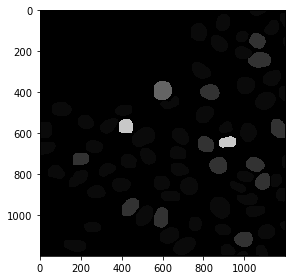

In [3]:
io.imshow(mask[10,:,:])  # different cell cycle phase is colored

Track the mask.

In [3]:
from pcnaDeep.tracker import track_mask
# instead of input mask labeled with cell-cycle specific value, the output mask is continuously labeled
tracked, labeled_mask = track_mask(mask, render_phase=True, displace=100, gap_fill=3)

Frame 65: 103 trajectories present.


Read in the raw images.

In [4]:
imgs = []
for i in os.listdir(os.path.join(example_root, 'MCF10A')):
    if i[-3:] == 'png':
        img = io.imread(os.path.join(example_root, 'MCF10A', i))
        imgs.append(img)
raw = np.stack(imgs, axis=0)

Generate `.trk` files. Note that `generate_calibanTrk( )` can perform mask-tracking by itself (for demostrating purpose we did not). We can suppress the behavior by supplying it with a tracked table.

In [5]:
from pcnaDeep.data.annotate import generate_calibanTrk
tracked_new = generate_calibanTrk(raw=raw, mask=labeled_mask, out_dir=os.path.join(example_root, 'MCF10A'), 
                    dt_id=1, digit_num=4, track=tracked)
tracked_new.to_csv(os.path.join(example_root, 'MCF10A', '0001_tracked.csv'), index=0)
tracked_new

,frame,trackId,lineageId,parentTrackId,Center_of_the_object_1,Center_of_the_object_0,predicted_class,Probability of G1/G2,Probability of S,Probability of M,continuous_label,major_axis,minor_axis,mean_intensity,mtParTrk,ori_trackId
0,0,1,1,0,39.150359,1128.490051,G1/G2,1,0,0,1,98.795516,63.036706,10,0,1
67,1,1,1,0,32.056595,1137.564796,G1/G2,1,0,0,1,89.761044,62.292804,10,0,1
142,2,1,1,0,28.237768,1144.653656,G1/G2,1,0,0,1,86.117956,55.263801,10,0,1
213,3,1,1,0,24.006911,1157.384315,G1/G2,1,0,0,2,83.184777,53.563012,10,0,1
285,4,1,1,0,20.664910,1165.991717,G1/G2,1,0,0,3,74.759067,48.080955,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,65,170,170,0,939.720416,879.167354,G1/G2,1,0,0,77,91.081957,85.092300,200,0,170
5387,62,171,171,0,7.975000,1187.371875,G1/G2,1,0,0,5,24.435036,17.520169,10,0,171
5597,64,206,171,171,7.853414,1180.202811,G1/G2,1,0,0,6,40.240005,17.285144,10,0,171
5655,64,172,172,0,758.254194,1188.285161,G1/G2,1,0,0,64,47.260946,22.222824,10,0,172


### &emsp;2.2 Manually label `.trk` file through deepcell-label software
To correct tracking error and label mitosis, use deepcell-label software. See [software homepage](https://github.com/vanvalenlab/deepcell-label) for detailed manual.

It is suggested that deepcell-label has the best performance when being run in a __Docker__ container.

### &emsp;2.3 Convert `.trk` _tracking ground truth_ to _mitosis lookup_ `.txt`

`pcnaDeep.data.annotate.mergeTrkAndTrack( )` reads in the file path of a `.trk` file (__tracks we just curated manually__) and tracked object table `.csv` (__output of mask tracking, i.e., the variable `track_new` we just saved__) and merges the two. During merging, the method raises/handles the following exceptions:
1. Gapped tracks still exist in `.trk` which should be separated already. A `ValueError` will be raised. Check your `.trk` manually.
2. Mitosis parent assigned does not have an 'M' classification before division. A `UserWarning` will be raised. The relationship will not be solved.
3. When correct mitosis relationship found, the function calculates mitosis entry and mitosis exit based on cell cycle classification. If no 'M' classification found for daughters, mitosis exit will be assigned to the first frame of daughters' appearance. Such daughter will be labeled with _imprecise_, and returned as a list.

The function returns:
1. __tracked object table__, `trackId, parentTrackId, lineageId, mtParTrk` corrected from `.trk`
2. __mitosis dictionary__, a standard mitosis information dictionary in pcnaDeep.
3. __imprecise daughters__, a list of daughter track IDs, the mitosis exit calculation is not precise.
4. (optional, default suppress output with parameter `mask_out = False`) __mask__ deduced from `.trk`.

In this case, we will need _tracked object table_ and _mitosis dictionary_.

In [23]:
from pcnaDeep.data.annotate import mergeTrkAndTrack
out = mergeTrkAndTrack(trk_path = os.path.join(example_root, 'MCF10A', '0001.trk'),
                      table_path = os.path.join(example_root, 'MCF10A', '0001_tracked.csv'),
                      return_mask = False)
track = out[0]
track.to_csv(os.path.join(example_root, 'MCF10A', '0001_tracked_GT.csv'), index=0)
mt_dic = out[1]

We then convert `mt_dic` to ___mitosis lookup matrix___ and save as a `.txt` file, using __`pcnaDeep.data.utils.mt_dic2_mt_lookup( )`__.

In [24]:
from pcnaDeep.data.utils import mt_dic2mt_lookup
mt_lookup = mt_dic2mt_lookup(mt_dic)
mt_lookup.to_csv(os.path.join(example_root, 'MCF10A', '0001_mitosis_lookup.txt'), index=0)

---

### 3. Extract _mitosis ground truth_ `array` from _mitosis lookup_ `.txt` as SVM training data
We can draw SVM training data from a `Refiner` object in `TRAIN` mode, by supplying an `numpy.array` mitosis lookup table to the method __`Refiner.get_SVM_train( )`__.

In [2]:
## Initialize Refiner object
# You may use the Refiner already have, just make sure Refiner.track matches to your mitosis lookup.
from pcnaDeep.refiner import Refiner
r = Refiner(track = pd.read_csv(os.path.join(example_root, 'MCF10A', '0001_tracked_GT.csv')), mode='TRAIN',
           sample_freq=20, mt_len=5) # remember to input metadata: sample frequency and mitosi length

In [3]:
## Read in lookup table
# skip header if essential (header in file)
mt_lookup_array = np.array(pd.read_csv(os.path.join(example_root, 'MCF10A', '0001_mitosis_lookup.txt'), header=0))

`Refiner.get_SVM_train( )` takes the parameter `random_negative` in case your lookup table does not contain any negative instances. It will sample negative instances at most same size as the positive instance, randomly from the tracked object table.

In [8]:
X, y = r.get_SVM_train(mt_lookup_array, random_negative=True, rand_size=500)

It is highly recommended to __save raw training feature map__ for extensibility.

In [9]:
X = np.array(X)
train = pd.DataFrame(X)
train['5'] = y
train.to_csv(os.path.join(example_root, 'MCF10A', 'SVM_train.txt'), header=0, index=0)

### 4. Initialize, Fit, Save the SVM model

__Feature map__ of the SVM model used in pcnaDeep:
1. Distance difference between parent (when it disappears) and daughter (when it appears),   
    normalized with average displace of the entire dataset.
2. Frame difference between parent (when it disappears) and daughter (when it apppears),   
    normalized with absolute time of mitosis (`sample_freq * mt_len`)
3. Mitosis score of parent * daughter

    mitosis score = sum_i(Indicator_{predicted_class = 'M'} * 0.9 ^ abs((t_i - t_mitosis_entry/exit)))
    
4. Difference of average major axis across track, normalized with parent value
5. Difference of average minor axis across track, normalized with parent value

In [10]:
X = np.array(X)
# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = np.array(y)

__Visualize the feature map__

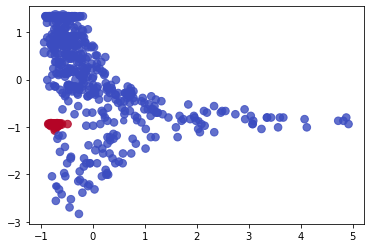

In [11]:
import matplotlib.pyplot as plt
sub = X[:,[0,1,2]]  # spatial and temporal distance and parent mitosis score, the first three features
plt.scatter(sub[:,0], sub[:,1], c=y, s=(- min(sub[:,2]) + sub[:,2])*10, alpha=0.8, cmap='coolwarm')

From the plot, we see that _spatial and temporal correlations_ are strong predictors of the mitosis relationship. However, _mitosis score_, a secondary feature derived from cell cycle classification, does not help much to discern mitosis pairs. We believe this is a result from inaccurate mitosis prediction and should be fixed with increasing training set.

__Fit the model__

In [12]:
from sklearn.svm import SVC
clf = SVC(probability=True, class_weight='balanced')
clf.fit(X, y)

SVC(class_weight='balanced', probability=True)

__Save the model__

In [13]:
import joblib
joblib.dump(clf, os.path.join(example_root, 'MCF10A', 'mitosis_svm.m'))

['/Users/jefft/Desktop/Chan lab/SRTP/ImageAnalysis/PCNAdeep/examples/MCF10A/mitosis_svm.m']

__Load the model and predict__

In [14]:
clf = joblib.load(os.path.join(example_root, 'MCF10A', 'mitosis_svm.m'))
ipt = [0, 0.63, 2.71, 1.0, 1.0]
scaler = StandardScaler()
scaler.fit([ipt])
clf.predict_proba(np.array([ipt]))  # even perfect distance match (=0), due to huge time difference (0.63), no relationship.

array([[0.99845155, 0.00154845]])

---

__For using SVM model in real tracking environment through `pcnaDeep.refiner.Refiner`__, see [Getting started](getting_started.ipynb).